In [102]:
#Basic Python Libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

#Pre Processing libraries
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
from sklearn import preprocessing

#Packages for feature engineering:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Import Machine Learning Models:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Import metrics for valdation:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#For imbalanced data
from imblearn.over_sampling import SMOTE



In [103]:
#Replace Desktop in below script by the folder name where you have  kept the python script  & the input file,
df = pd.read_csv("~\\Desktop\\Usecase3_Dataset.csv")



In [104]:
print(df.shape)
print(df.columns)

(14640, 3)
Index(['airline_sentiment', 'airline', 'text'], dtype='object')


In [105]:
#Number of sentiments againts each airline
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [106]:
#Check for missing values in the dataset
df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [107]:
#Distrubtion of sentiments
df['airline_sentiment'].value_counts()/len(df)*100
#63% of feedback is negative

negative    62.691257
neutral     21.168033
positive    16.140710
Name: airline_sentiment, dtype: float64

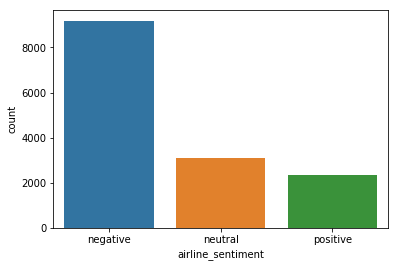

In [108]:
#Graphical representation of airline sentiment
sns.countplot(x='airline_sentiment',data=df,order=['negative','neutral','positive'])
plt.show()

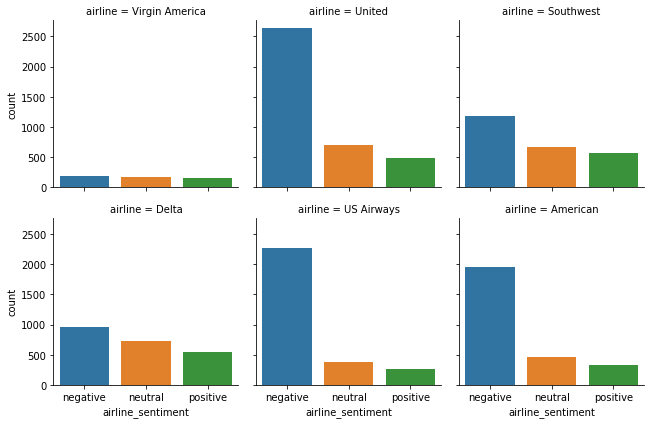

In [109]:
#Graphical representation of airline sentiment for different airlines
sns.factorplot(x = 'airline_sentiment',data=df,
               order = ['negative','neutral','positive'],kind = 'count',col='airline',size=3,col_wrap = 3)
              
plt.show()

#From below plot we can see customer are not happy with airline United , US Airways and American 
#& have lots of negative feedback

In [110]:
pd.crosstab(df['airline'],df['airline_sentiment']).apply(lambda r: r/r.sum(), axis=1)
#From below cross table we can see airlines United , US Airways and American  have more then 70% negative sentiments


airline_sentiment,negative,neutral,positive
airline,,,
American,0.710402,0.167814,0.121783
Delta,0.429793,0.325383,0.244824
Southwest,0.490083,0.274380,0.235537
US Airways,0.776862,0.130793,0.092345
United,0.688906,0.182365,0.128728
Virgin America,0.359127,0.339286,0.301587


In [111]:
df.columns

Index(['airline_sentiment', 'airline', 'text'], dtype='object')

In [112]:
#Data pre processing
#remove words which are starts with @ symbols
df['text'] = df['text'].map(lambda x:re.sub('@\w*','',str(x)))
#remove special characters except [a-zA-Z]
df['text'] = df['text'].map(lambda x:re.sub('[^a-zA-Z]',' ',str(x)))
#remove link starts with https
df['text'] = df['text'].map(lambda x:re.sub('http.*','',str(x)))

In [113]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
corpus = df['text']

def clean(doc):
    doc = doc.lower()
    #Stopword Removal
    #Punctuation Removal
    #Lemmatization to convert words to it root form
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word, pos = 'v' ) for word in punc_free.split())
    return normalized
    

corpus = [clean(doc) for doc in corpus]

In [114]:
df['text_cleaned'] = corpus

In [115]:
#Label encoding:
label_encoder = preprocessing.LabelEncoder()
df['airline_sentiment_encoded'] = label_encoder.fit_transform(list(df['airline_sentiment']))


In [116]:
df['airline_sentiment_encoded'].value_counts()

0    9178
1    3099
2    2363
Name: airline_sentiment_encoded, dtype: int64

In [117]:
#To check  what labels are  given
list(label_encoder.classes_)


['negative', 'neutral', 'positive']

In [118]:
#To get exact label  name from values
list(label_encoder.inverse_transform([0, 1, 2]))

['negative', 'neutral', 'positive']

In [119]:
#Create X(independent) and y(dependent) variables for further  split
X = df['text_cleaned']
y = df['airline_sentiment_encoded']

In [120]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(11712,) (2928,) (11712,) (2928,)


In [121]:
#Feature Engineering 
#CountVectorizer 
vect = CountVectorizer()
#Fit the training data:
vect.fit(X_train)
#Transform the training & testing data
X_train_count_vect = vect.transform(X_train)
X_test_count_vect = vect.transform(X_test)

In [122]:
#CountVectorizer with ngram
vect_ngram = CountVectorizer(ngram_range = (1,2))
#Fit the training data:
vect_ngram.fit(X_train)
#Transform the training & testing data
X_train_count_vect_ngram = vect_ngram.transform(X_train)
X_test_count_vect_ngram = vect_ngram.transform(X_test)

In [123]:
#TfidfVectorizer with ngram
vect_tf = TfidfVectorizer(ngram_range = (1,2),max_features=50000)
vect_tf.fit(X_train)
#Transform the training & testing data
X_train_tfidf = vect_tf.transform(X_train)
X_test_tfidf = vect_tf.transform(X_test)

In [124]:
#Count number  of features 
len(vect_tf.get_feature_names())

50000

In [125]:
#Naive Bayes Model:
#Initilization:
nb_count_vect = MultinomialNB(alpha = 0.10,fit_prior = False)
nb_count_vect_ngram = MultinomialNB(alpha = 0.10,fit_prior = False)
nb_tfidf = MultinomialNB(alpha = 0.10,fit_prior = False)
#Train the model:
import random
random.seed(110)
nb_count_vect.fit(X_train_count_vect,y_train)
nb_count_vect_ngram.fit(X_train_count_vect_ngram,y_train)
nb_tfidf.fit(X_train_tfidf,y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False)

In [126]:
#Prediction on test data:
y_pred_nb_count_vect = nb_count_vect.predict(X_test_count_vect)
y_pred_nb_count_vect_ngram = nb_count_vect_ngram.predict(X_test_count_vect_ngram)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

In [127]:
#Calculate accuracy of class prediction:
print('Naive Bayes Model With CountVectorizer:',accuracy_score(y_test,y_pred_nb_count_vect))
print('Naive Bayes Model With CountVectorizer & ngram:',accuracy_score(y_test,y_pred_nb_count_vect_ngram))
print('Naive Bayes Model With TFIDF & ngram:',accuracy_score(y_test,y_pred_nb_tfidf))

Naive Bayes Model With CountVectorizer: 0.7564890710382514
Naive Bayes Model With CountVectorizer & ngram: 0.7687841530054644
Naive Bayes Model With TFIDF & ngram: 0.7756147540983607


In [128]:
print('Naive Bayes Model With CountVectorizer:')
print(classification_report(y_test,y_pred_nb_count_vect))
print('Naive Bayes Model With CountVectorizer & ngram:')
print(classification_report(y_test,y_pred_nb_count_vect_ngram))
print('Naive Bayes Model With TFIDF & ngram:')
print(classification_report(y_test,y_pred_nb_tfidf))

Naive Bayes Model With CountVectorizer:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1870
           1       0.55      0.59      0.57       614
           2       0.62      0.74      0.68       444

    accuracy                           0.76      2928
   macro avg       0.68      0.72      0.70      2928
weighted avg       0.77      0.76      0.76      2928

Naive Bayes Model With CountVectorizer & ngram:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1870
           1       0.60      0.55      0.57       614
           2       0.65      0.70      0.68       444

    accuracy                           0.77      2928
   macro avg       0.70      0.70      0.70      2928
weighted avg       0.77      0.77      0.77      2928

Naive Bayes Model With TFIDF & ngram:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1870
   

In [129]:
#From above classification reoport its seen we are getting decent f1 score with TFID + Ngram.
#So we will try other machine models with TFIDF + ngram
#One thing to notice is eventhough overall F1 score is 77% f1 score for 1 and 2 is less.

In [130]:
#Logistic Regression Model:
#Initilization:
model_log = LogisticRegression()

#Train the model:
random.seed(150)
model_log.fit(X_train_tfidf,y_train)

#Prediction on test data:
y_pred_model_log = model_log.predict(X_test_tfidf)



C:\Users\sunny\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [131]:
#Calculate accuracy of class prediction:
print('Logistic Regression Model With TFIDF & ngram:',accuracy_score(y_test,y_pred_model_log))


Logistic Regression Model With TFIDF & ngram: 0.7773224043715847


In [132]:
print('Logistic Regression Model With TFIDF & ngram:')
print(classification_report(y_test,y_pred_model_log))

Logistic Regression Model With TFIDF & ngram:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1870
           1       0.71      0.38      0.50       614
           2       0.82      0.55      0.66       444

    accuracy                           0.78      2928
   macro avg       0.77      0.63      0.67      2928
weighted avg       0.77      0.78      0.75      2928



In [133]:
#Support Vector Machine Model:
#Initilization:
model_svm = LinearSVC(random_state=0)
#Train the model:
random.seed(200)
model_svm.fit(X_train_tfidf,y_train)

#Prediction on test data:
y_pred_model_svm = model_svm.predict(X_test_tfidf)

In [134]:
#Calculate accuracy of class prediction:
print('SVM Model With TFIDF & ngram:',accuracy_score(y_test,y_pred_model_svm))


SVM Model With TFIDF & ngram: 0.7889344262295082


In [135]:
print('SVM Model With TFIDF & ngram:')
print(classification_report(y_test,y_pred_model_svm))

SVM Model With TFIDF & ngram:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1870
           1       0.65      0.47      0.55       614
           2       0.77      0.64      0.70       444

    accuracy                           0.79      2928
   macro avg       0.75      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928



In [136]:
#Running SMOTE to resolve issue of imbalanced data
smt = SMOTE(random_state = 777,k_neighbors = 1)
X_SMOTE,y_SMOTE = smt.fit_sample(X_train_tfidf,y_train)

In [137]:
#Support Vector Machine Model with SMOTE:
#Initilization:
model_svm_smote = LinearSVC(random_state=0,tol=1e-5)
#Train the model:
random.seed(800)
model_svm_smote.fit(X_SMOTE,y_SMOTE)

#Prediction on test data:
y_pred_model_svm_smote = model_svm_smote.predict(X_test_tfidf)

In [138]:
#Calculate accuracy of class prediction:
print('SVM Model With TFIDF & ngram:',accuracy_score(y_test,y_pred_model_svm_smote))

SVM Model With TFIDF & ngram: 0.7776639344262295


In [139]:
print('SVM Model With TFIDF & ngram:')
print(classification_report(y_test,y_pred_model_svm_smote))

SVM Model With TFIDF & ngram:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1870
           1       0.62      0.50      0.55       614
           2       0.72      0.61      0.66       444

    accuracy                           0.78      2928
   macro avg       0.72      0.67      0.69      2928
weighted avg       0.77      0.78      0.77      2928



In [140]:
print(len(y_SMOTE))
print(len(y_train))

21924
11712


In [141]:
#Random Forest Model:
#Initilization:
model_rf = RandomForestClassifier()
#Train the model:
random.seed(231)
model_rf.fit(X_train_tfidf,y_train)

#Prediction on test data:
y_pred_model_rf = model_rf.predict(X_test_tfidf)

In [142]:
#Calculate accuracy of class prediction:
print('Random Forest Model With TFIDF & ngram:',accuracy_score(y_test,y_pred_model_rf))

Random Forest Model With TFIDF & ngram: 0.7667349726775956


In [143]:
print('Random Forest Model With TFIDF & ngram:')
print(classification_report(y_test,y_pred_model_rf))

Random Forest Model With TFIDF & ngram:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85      1870
           1       0.61      0.49      0.54       614
           2       0.75      0.55      0.64       444

    accuracy                           0.77      2928
   macro avg       0.72      0.65      0.68      2928
weighted avg       0.76      0.77      0.76      2928



In [144]:
#XG Boosting:
#Initilization:
model_xgb = XGBClassifier()
#Train the model:
random.seed(305)
model_xgb.fit(X_train_tfidf,y_train)

#Prediction on test data:
y_pred_model_xgb = model_xgb.predict(X_test_tfidf)

In [145]:
#Calculate accuracy of class prediction:
print('XGB Model With TFIDF & ngram:',accuracy_score(y_test,y_pred_model_xgb))


XGB Model With TFIDF & ngram: 0.766051912568306


In [146]:
print('XGB Model With TFIDF & ngram:')
print(classification_report(y_test,y_pred_model_xgb))

XGB Model With TFIDF & ngram:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1870
           1       0.64      0.44      0.52       614
           2       0.71      0.64      0.67       444

    accuracy                           0.77      2928
   macro avg       0.72      0.66      0.68      2928
weighted avg       0.75      0.77      0.75      2928



In [147]:
'''Grid Search CV
from sklearn.model_selection import GridSearchCV
grid_mod = RandomForestClassifier()
parameters = {'max_depth' : [3,5,10],'n_estimators' : [100,200,300,400,500],
             'max_features' : [5000,10000,15000], 'criterion' : ['gini','entropy']}
grid_search = GridSearchCV(estimator = grid_mod, param_grid = parameters, scoring = 'accuracy',
                           cv = 5,n_jobs = -1)
grid_search = grid_search.fit(X_train_tfidf,y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
'''

"Grid Search CV\nfrom sklearn.model_selection import GridSearchCV\ngrid_mod = RandomForestClassifier()\nparameters = {'max_depth' : [3,5,10],'n_estimators' : [100,200,300,400,500],\n             'max_features' : [5000,10000,15000], 'criterion' : ['gini','entropy']}\ngrid_search = GridSearchCV(estimator = grid_mod, param_grid = parameters, scoring = 'accuracy',\n                           cv = 5,n_jobs = -1)\ngrid_search = grid_search.fit(X_train_tfidf,y_train)\nprint(grid_search.best_score_)\nprint(grid_search.best_params_)\n"

In [148]:
#Identification of themes among different airlines:
#Function to fecth  top words from sentiments
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [149]:
df.columns


Index(['airline_sentiment', 'airline', 'text', 'text_cleaned',
       'airline_sentiment_encoded'],
      dtype='object')

In [150]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [151]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [152]:
df_united = df[(df['airline'] == 'United') & (df['airline_sentiment'] == 'negative')]
df_usairways = df[(df['airline'] == 'US Airways') & (df['airline_sentiment'] == 'negative')]
df_american = df[(df['airline'] == 'American') & (df['airline_sentiment'] == 'negative')]
df_southwest = df[(df['airline'] == 'Southwest') & (df['airline_sentiment'] == 'negative')]
df_delta = df[(df['airline'] == 'Delta') & (df['airline_sentiment'] == 'negative')]
df_virgin = df[(df['airline'] == 'Virgin America') & (df['airline_sentiment'] == 'negative')]

In [153]:
def word_chart(negative_sent,val):
    count_vectorizer = CountVectorizer(stop_words='english')
    words, word_values = get_top_n_words(n_top_words=15,count_vectorizer=count_vectorizer, text_data=negative_sent)
    fig, ax = plt.subplots(figsize=(16,8))
    ax.bar(range(len(words)), word_values);
    ax.set_xticks(range(len(words)));
    ax.set_xticklabels(words, rotation='vertical');
    ax.set_title(val);
    ax.set_xlabel('Word');
    ax.set_ylabel('Number of occurences');
    plt.show()

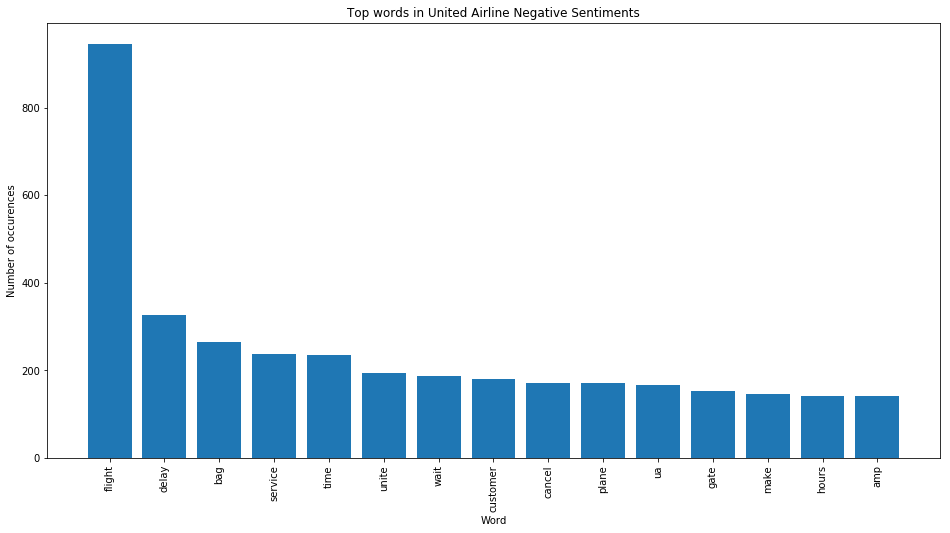

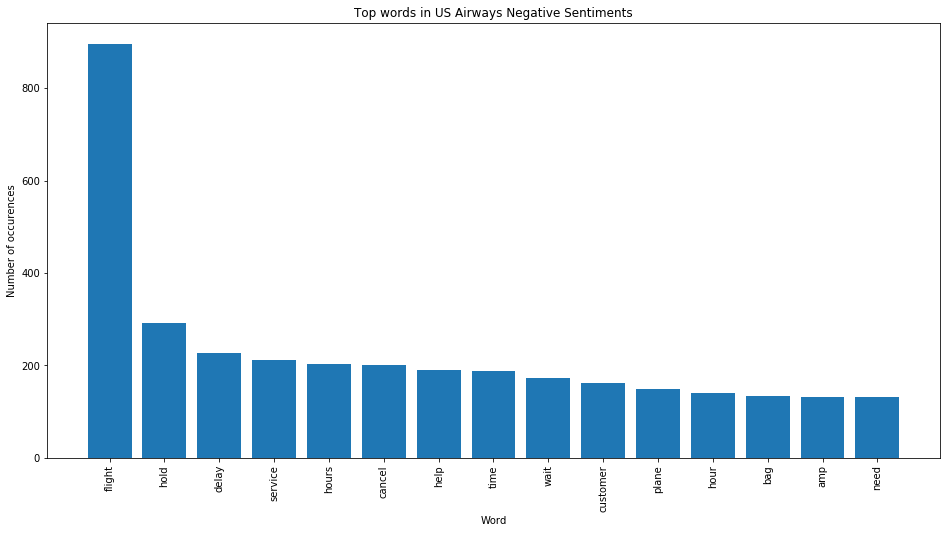

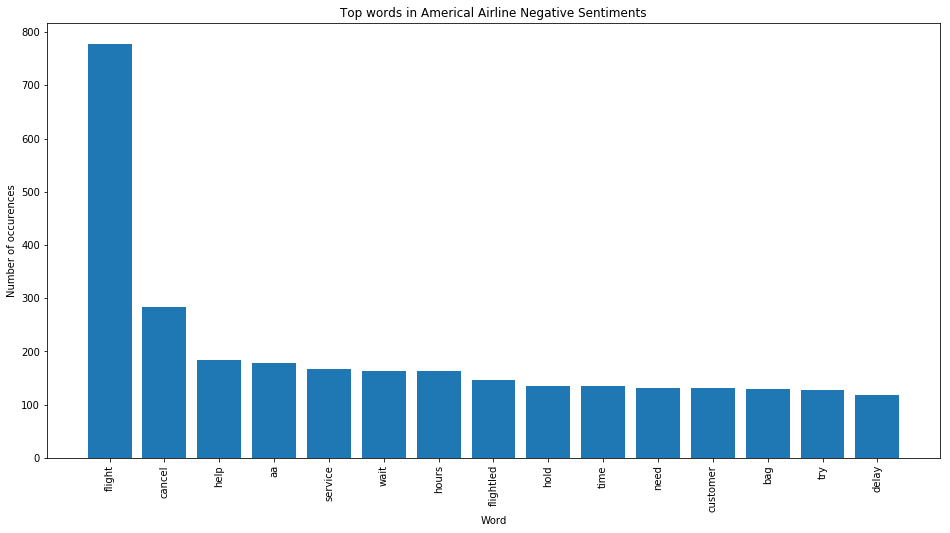

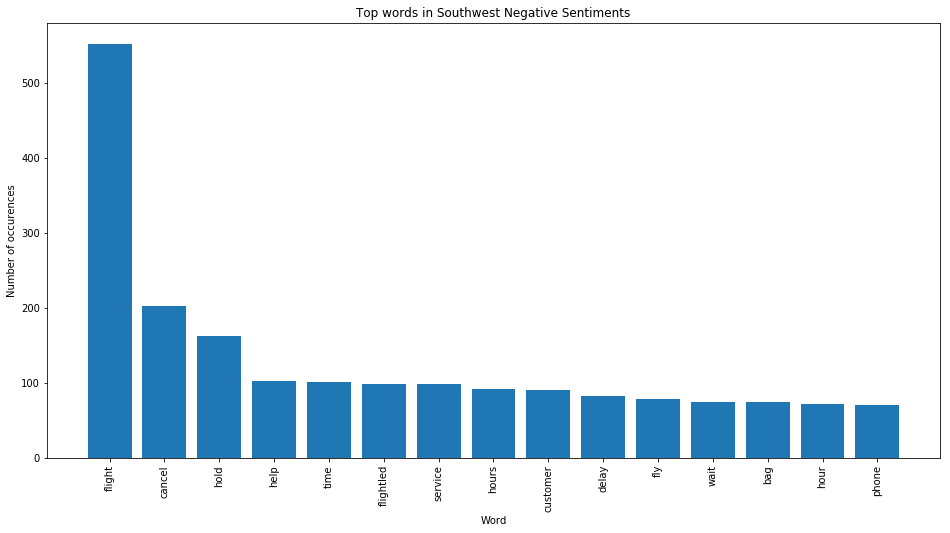

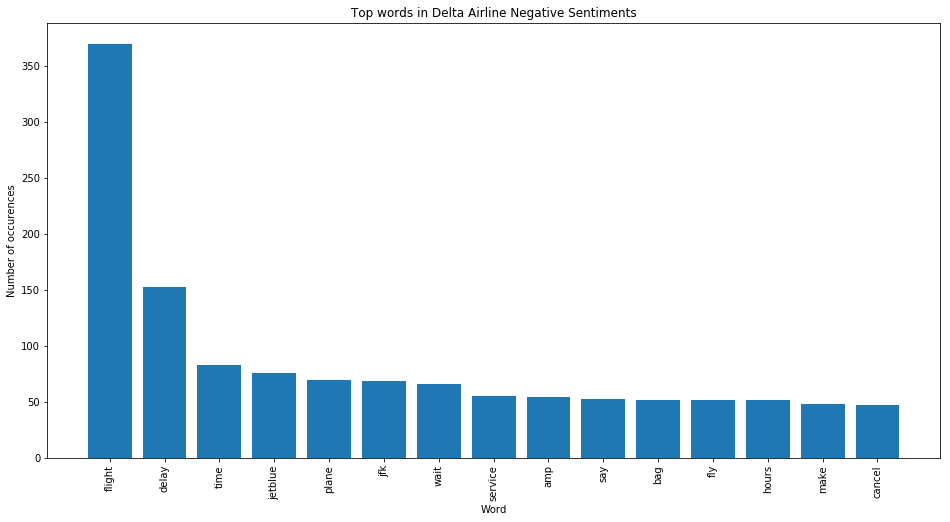

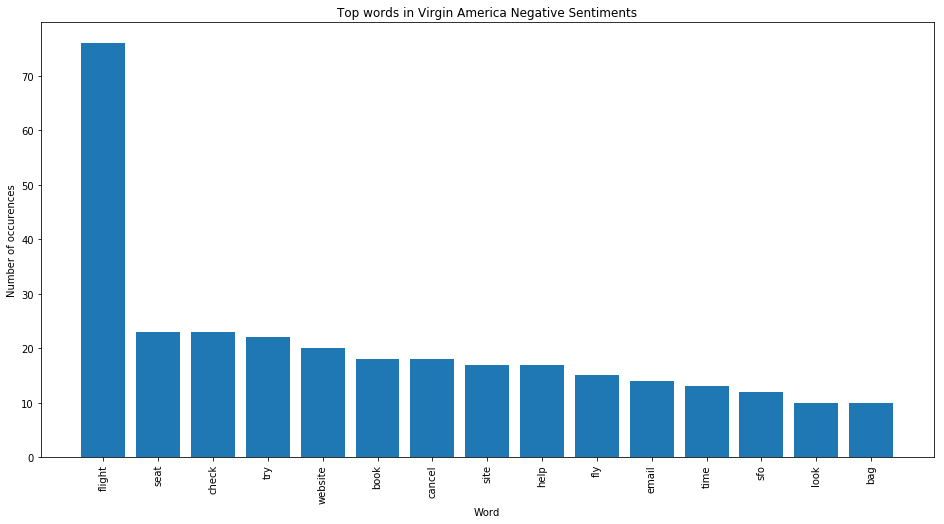

In [154]:
word_chart(df_united['text_cleaned'],'Top words in United Airline Negative Sentiments')
word_chart(df_usairways['text_cleaned'], 'Top words in US Airways Negative Sentiments')
word_chart(df_american['text_cleaned'],'Top words in Americal Airline Negative Sentiments')
word_chart(df_southwest['text_cleaned'], 'Top words in Southwest Negative Sentiments')
word_chart(df_delta['text_cleaned'],'Top words in Delta Airline Negative Sentiments')
word_chart(df_virgin['text_cleaned'], 'Top words in Virgin America Negative Sentiments')

In [ ]:
#From above chart its seen that theme around differet airlines are almost same i.e delay  in flights,
#hold for long time, baggage relates issues, poor customer service, cancelled flights.
#For Virgin America airline which have lowest negative sentiments also have 
#different themes i.e website down, booking related problems 